In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import pickle as pkl
import os

In [2]:
# set up original camera matrix
f = 300
K = np.diag([300, 300, 1])
K[0, 2] = f // 2
K[1, 2] = f // 2

C = np.array([0, 0, 0, 1])

P = K @ (np.hstack([np.eye(3), -(C[:3] / C[3]).reshape(-1, 1)]))
P

array([[300.,   0., 150.,   0.],
       [  0., 300., 150.,   0.],
       [  0.,   0.,   1.,   0.]])

In [3]:
# def generate_points(n, seed=0):
#    """Generate n random points in 3D space"""
#     np.random.seed(seed)
#     points = np.random.uniform(-1, 1, (n, 4))
#     points[:, 0] *= 2
#     points[:, 1] *= 2
#     points[:, 2] += 5
#     points[:, 3] = 1
#     return points

def generate_points(rows, cols):
    """Generate nxn grid of points in 3D space around Z axis"""
    center = np.array([0, 0, 5, 1])
    # make an n by n grid surrounding the center
    x = np.linspace(-0.1 * cols, 0.1 * cols, cols)
    y = np.linspace(-0.1 * rows, 0.1 * rows, rows)
    yy, xx = np.meshgrid(x, y)
    points = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    points = np.hstack([points, np.zeros((rows * cols, 1)), np.ones((rows * cols, 1))])
    points += center
    return points

def get_rotated_camera(K, C, x=0, y=0, z=0):
    """Apply a rotation to a camera matrix"""
    R = np.eye(3)
    R = R @ cv2.Rodrigues(np.array([x, y, z]))[0]
    P = K @ np.hstack([R, -(C[:3] / C[3]).reshape(-1, 1)])
    return P

def get_normalizing_transform(X):
    """Get a normalizing transformation matrix for a set of identified points"""
    N = X.shape[0]

    # get centroid
    c_x = X[:, 0].mean()
    c_y = X[:, 1].mean()

    # get T
    denom = (np.sqrt((X[:, 0] - c_x) ** 2 + (X[:, 1] - c_y) ** 2 )).sum()
    s = N * 2 ** 0.5 / denom
    t_x = -s * c_x
    t_y = -s * c_y
    T = np.eye(3) * s
    T[:, 2] = np.array([t_x, t_y, 1])
    return T

def get_homography(X1, X2, normalize=False):
    """Get the homography matrix that maps X1 to X2"""
    # get normalizing transformation matrices
    T1 = get_normalizing_transform(X1)
    T2 = get_normalizing_transform(X2)

    n = X1.shape[0]

    # normalize each matrix
    X1n = np.hstack([X1, np.ones((n, 1))]) @ T1.T
    X2n = np.hstack([X2, np.ones((n, 1))]) @ T2.T

    # build A
    A = np.array([]).reshape(0, 9)
    for i in range(n):
        xip, yip, wip = X2n[i, :]
        xi = X1n[i, :].reshape(1, 3)
        row1 = np.hstack([np.zeros((1, 3)), -wip* xi, yip * xi])
        row2 = np.hstack([wip * xi, np.zeros((1, 3)), -xip * xi])
        A = np.vstack([A, row1, row2])

    # solve for homography in normalized coordinates
    _, _, V = np.linalg.svd(A)
    Hn = V[8, :].reshape(3, 3)

    # undo normalize transformation
    H = np.linalg.inv(T2) @ Hn @ T1

    # normalize to det(H) = 1
    if normalize:
        det = np.linalg.det(H)
        factor = np.sign(det) * np.abs(det) ** (1 / 3)
        H /= factor
    return H

def apply_homography(Iin, H, bounds=None):
    """Apply a homography to a full image"""
    n, m = Iin.shape[:2]

    # find bounds of image, then build mesh in rectified space
    I_corners = np.array([[0, 0], [0, m - 1], [n - 1, 0], [n - 1, m - 1]])
    Iph_corners = np.hstack([I_corners, np.ones((4, 1))]) @ H.T
    Ip_corners = Iph_corners[:, :2] / Iph_corners[:, 2].reshape(-1, 1)

    if bounds is None:
        imin, jmin = Ip_corners.min(axis=0)
        imax, jmax = Ip_corners.max(axis=0)
    else:
        imin, jmin, imax, jmax = bounds

    ii, jj = np.meshgrid(np.linspace(imin, imax, n), np.linspace(jmin, jmax, m), indexing='ij')
    Xp = np.vstack([ii.ravel(), jj.ravel(), np.ones(n * m)]).T

    # find corresponding points in the original space by solving the equation
    # X^T = H^-1 @ X'^T  ->  H @ X^T = X'^T
    Xh = np.linalg.lstsq(H, Xp.T, rcond=None)[0].T
    X = Xh[:, :2] / Xh[:, 2].reshape(-1, 1)

    # For a point in Ip, its corresponding point in I is found at a coordinate in X
    res = np.zeros((n, m, 3))
    for i in range(3):
        I = Iin[:, :, i]
        interpolator = scipy.interpolate.RegularGridInterpolator(
            (np.arange(I.shape[0]), np.arange(I.shape[1])),
            I,
            bounds_error=False,
            fill_value=0
        )
        Ip = interpolator(X).reshape(m, n)
        res[:, :, i] = Ip
    return np.clip(res, 0, 1)

In [4]:
def points_to_image(points2d, h=300, w=300, r=5):
    """Convenience function that converts matplotlib points to an image"""
    arr = np.ones((h, w, 3))
    for i in range(h):
        for j in range(w):
            # check if pixel is within r of any point
            for k in range(points2d.shape[0]):
                point = points2d[k, :]
                if np.linalg.norm(np.array([i, j]) - point) < r:
                    if k == 0:
                        arr[i, j] = np.array([1, 0, 0])
                    elif k == 1:
                        arr[i, j] = np.array([0, 1, 0])
                    else:
                        arr[i, j] = np.array([0, 0, 1])
                    break
    return arr

def plot_points_as_image(*points2d, titles=None):
    """Plot points with same coordinate system as plt.imshow (inverted y axis, row-first)"""
    n = len(points2d)
    fig = plt.figure(figsize=(5 * n, 5))
    for i in range(n):
        points = points2d[i]
        ax = fig.add_subplot(1, n, i + 1)
        ax.scatter(points[:, 1], points[:, 0])
        ax.scatter([points[0, 1]], [points[0, 0]], c='r')
        ax.scatter([points[1, 1]], [points[1, 0]], c='g')
        ax.set_aspect('equal')
        ax.set_xlim(0, 300)
        ax.set_ylim(300, 0)
        if titles is not None:
            ax.set_title(titles[i])
    plt.show()

def plot_multiple_images(*images, titles=None):
    """Plot multiple images in a row"""
    n = len(images)
    fig = plt.figure(figsize=(5 * n, 5))
    for i in range(n):
        ax = fig.add_subplot(1, n, i + 1)
        ax.imshow(images[i])
        if titles is not None:
            ax.set_title(titles[i])
    plt.show()

In [5]:
P_30z = get_rotated_camera(K, C, z=np.pi/6)
P_15x = get_rotated_camera(K, C, x=np.pi/12)

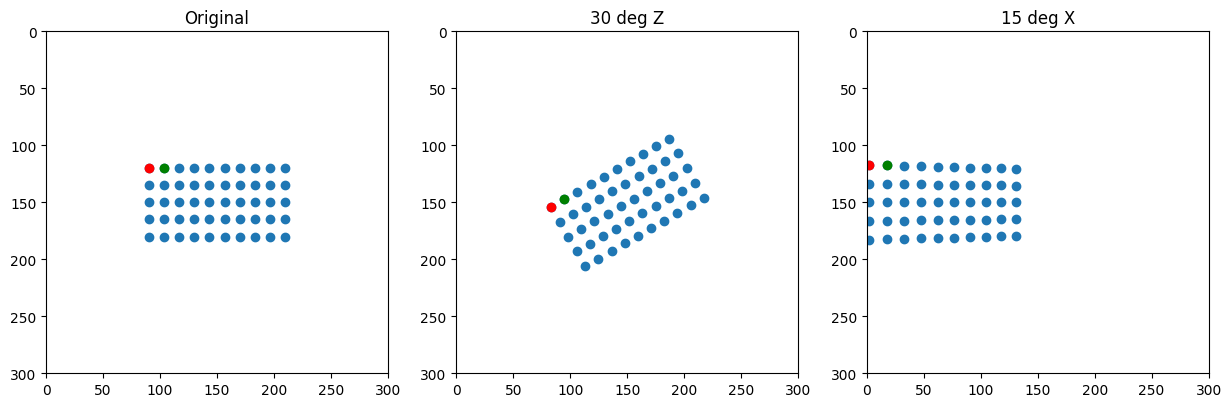

In [6]:
# may be wrong
# x left-right, y top-bottom, z near-far

# orig starts bottom-up, left-right
# rotation via image correctly goes 30 deg clockwise, based on z axis
# with matplotlib, first column is x (left-right), second is y (bottom-up)

# when working with creating the image, we need to flip the y axis, and make sure that the axis order is correct (ij does top-down, left-right)
points_3dh = generate_points(5, 10)
points_2dh_orig = points_3dh @ P.T
points_2d_orig = points_2dh_orig[:, :2] / points_2dh_orig[:, 2].reshape(-1, 1)

points_2dh_30z = points_3dh @ P_30z.T
points_2d_30z = points_2dh_30z[:, :2] / points_2dh_30z[:, 2].reshape(-1, 1)

points_2dh_15x = points_3dh @ P_15x.T
points_2d_15x = points_2dh_15x[:, :2] / points_2dh_15x[:, 2].reshape(-1, 1)

plot_points_as_image(points_2d_orig, points_2d_30z, points_2d_15x, titles=['Original', '30 deg Z', '15 deg X'])

In [9]:
if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('data/image_orig.pkl'):
    image_orig = points_to_image(points_2d_orig)
    with open('data/image_orig.pkl', 'wb') as f:
        pkl.dump(image_orig, f)
else:
    with open('data/image_orig.pkl', 'rb') as f:
        image_orig = pkl.load(f)

if not os.path.exists('data/image_30z.pkl'):
    image_30z = points_to_image(points_2d_30z)
    with open('data/image_30z.pkl', 'wb') as f:
        pkl.dump(image_30z, f)
else:
    with open('data/image_30z.pkl', 'rb') as f:
        image_30z = pkl.load(f)

if not os.path.exists('data/image_15x.pkl'):
    image_15x = points_to_image(points_2d_15x)
    with open('data/image_15x.pkl', 'wb') as f:
        pkl.dump(image_15x, f)
else:
    with open('data/image_15x.pkl', 'rb') as f:
        image_15x = pkl.load(f)

H_30z = get_homography(points_2d_30z, points_2d_orig, normalize=True)
H_15x = get_homography(points_2d_15x, points_2d_orig, normalize=True)
rectified_image_30z = apply_homography(image_30z, H_30z, (0, 0, 300, 300))
rectified_image_15x = apply_homography(image_15x, H_15x, (0, 0, 300, 300))

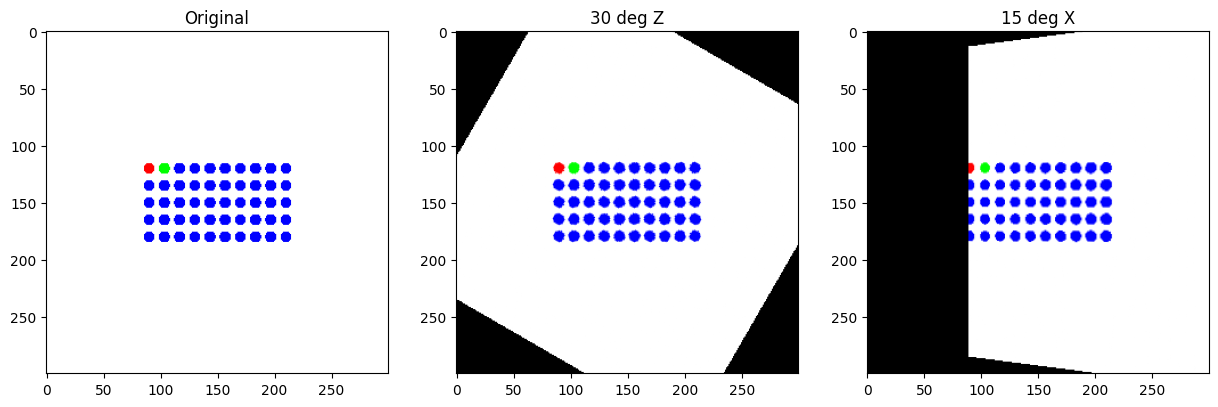

In [8]:
plot_multiple_images(image_orig, rectified_image_30z, rectified_image_15x, titles=['Original', '30 deg Z', '15 deg X'])

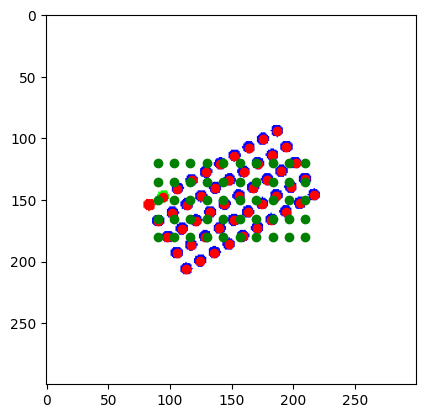

In [9]:
plt.imshow(image_30z)
plt.scatter(points_2d_30z[:, 1], points_2d_30z[:, 0], c='r')

rectified_points = np.hstack([points_2d_30z, np.ones((points_2d_30z.shape[0], 1))]) @ H_30z.T
rectified_points = rectified_points[:, :2] / rectified_points[:, 2].reshape(-1, 1)
plt.scatter(rectified_points[:, 1], rectified_points[:, 0], c='g')

In [21]:
H1 = get_homography(points_2d_orig, points_2d_30z, normalize=True)
H2 = get_homography(points_2d_orig, points_2d_15x, normalize=True)
H1_inv = np.linalg.inv(H1)
H2_inv = np.linalg.inv(H2)

H_invs = [H1_inv, H2_inv]

A = np.zeros((0, 6))

for i in range(2):
    h1, h2, h3, h4, h5, h6, h7, h8, h9 = H_invs[i].ravel()

    row1 = np.array([h1**2 - 1, 2*h1*h4, 2*h1*h7, h4**2, 2*h4*h7, h7**2])
    row2 = np.array([h1*h2, h1*h5+h2*h4 - 1, h1*h8+h2*h7, h4*h5, h4*h8+h5*h7, h7*h8])
    row3 = np.array([h1*h3, h1*h6+h3*h4, h1*h9+h3*h7 - 1, h4*h6, h4*h9+h6*h7, h7*h9])
    row4 = np.array([h2**2, 2*h2*h5, 2*h2*h8, h5**2 - 1, 2*h5*h8, h8**2])
    row5 = np.array([h2*h3, h2*h6+h3*h5, h2*h9+h3*h8, h5*h6, h5*h9+h6*h8 - 1, h8*h9])
    row6 = np.array([h3**2, 2*h3*h6, 2*h3*h9, h6**2, 2*h6*h9, h9**2 - 1])

    A = np.vstack([A, row1, row2, row3, row4, row5, row6])


In [ ]:
def reconstruct_k(coeffs):
    """Reconstruct a camera matrix from the IAC conic coefficients"""
    w = np.array([
        [coeffs[0], coeffs[1], coeffs[2]],
        [coeffs[1], coeffs[3], coeffs[4]],
        [coeffs[2], coeffs[4], coeffs[5]]
    ])
    
    w /= w[2, 2]

    U = np.linalg.cholesky(w, upper=False)
    K = np.linalg.inv(U).T
    K /= K[2, 2]
    return K

In [37]:
_, _, V = np.linalg.svd(A)
w_vector = V[-1, :]

# temp = reconstruct_k(w_vector)
# temp /= temp[2, 2]
# temp *= 1.5
# temp

temp = reconstruct_k(w_vector)
temp

array([[ 3.67423461e+02, -1.41548929e-11,  1.83711731e+02],
       [-0.00000000e+00,  3.67423461e+02,  1.83711731e+02],
       [-0.00000000e+00, -0.00000000e+00,  1.22474487e+00]])

In [14]:
H = get_homography(points_2d_30z, points_2d_15x)
det = np.linalg.det(H)
factor = np.sign(det) * np.abs(det) ** (1 / 3)
Hn = H / factor

Hn_inv = np.linalg.inv(Hn)

U = np.linalg.inv(K).T
w = U @ U.T
w

array([[ 1.11111111e-05,  0.00000000e+00, -1.66666667e-03],
       [ 0.00000000e+00,  1.11111111e-05, -1.66666667e-03],
       [-1.66666667e-03, -1.66666667e-03,  1.50000000e+00]])

In [15]:
calc_w = Hn_inv.T @ w @ Hn_inv

In [16]:
(np.abs(calc_w - w) < 1e-10).all()

np.True_

In [17]:
recover_U = np.linalg.cholesky(w, upper=False)
recover_K = np.linalg.inv(recover_U).T
recover_K

array([[300.,   0., 150.],
       [ -0., 300., 150.],
       [ -0.,   0.,   1.]])